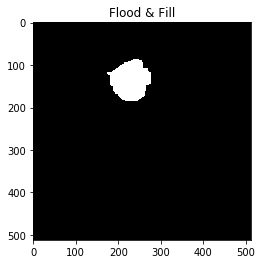

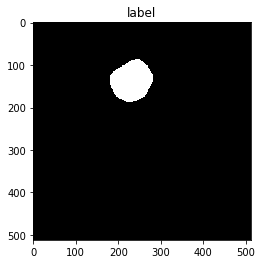

0.09772458240168358 0.0413055254605


In [8]:
# -*- coding: UTF-8 -*- 
# stokcy
# python 3.5

# For Flood and Fill algorithnm

import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import math
import numpy as py
import copy
#输入nii文件路径，输出文件对象和标记对象
slice_directory = '/home/chenyx/Liver_cancer/9'
for s in os.listdir(slice_directory):
    if s == 'Untitled.nii':
        label_name = s
    else:
        slice_name = s
print slice_name
def load_scan(path,slice_name,label_name):
    
    slices_directory = slice_directory+'/'+slice_name;
    slices = nib.load(slices_directory)
    label_directory = slice_directory+'/'+label_name;
    label = nib.load(label_directory)
    return slices,label

def get_pixels(slices):
    
    slice_vol_data = slices.get_data()
    slice_vol_data = (np.array(slice_vol_data[:,:,0])).astype('int16')
    slice_ref_affine = slices.affine

    return slice_vol_data,slice_ref_affine

def find_seed(label,slices):
    row = [s for s in range(0,label.shape[0]) if sum(label[s,:]) != 0];
    col = [s for s in range(0,label.shape[1]) if sum(label[:,s]) != 0];
    return int((row[0] + row[-1]) / 2) , int((col[0] + col[-1]) / 2);

def label_mean(label,slices):
    row = [s for s in range(0,label.shape[0]) if sum(label[s,:]) != 0];
    col = [s for s in range(0,label.shape[1]) if sum(label[:,s]) != 0];
    totalnum0 = 0;
    totalpix0 = 0;
    for r in range(len(row)):
        for c in range(len(col)):
            if label[row[r],col[c]] != 0:
                totalnum0 = totalnum0 + 1;
                totalpix0 = totalpix0 + slices[row[r],col[c]];
    totalnum1 = 0;
    totalpix1 = 0;
    for r in range(len(row)):
        for c in range(len(col)):
                totalnum1 = totalnum1 + 1;
                totalpix1 = totalpix1 + slices[row[r],col[c]];           
                
    return totalpix0 / totalnum0,totalpix1 / totalnum1;

import copy
slices,label = load_scan(slice_directory,slice_name,label_name)
slice_vol_data,slice_ref_affine = get_pixels(slices)
label_vol_data,label_ref_affine = get_pixels(label)

slices = copy.deepcopy(slice_vol_data);
label = copy.deepcopy(label_vol_data);

def floodfill(slices,seed):
    neighbor=[[-1,0],[0,1],[1,0],[0,-1],[-1,1],[-1,-1],[1,-1],[1,1]];

    area_maxdist = 6;

    new_slices = copy.deepcopy(slices); 
    area_mean = seed[2];
    area_num = 1;
    pix_dist = 0;
    
    nodelist = [];
    current_node = seed;
    new_slices[seed[0],seed[1]] = 1000;
    
    while  pix_dist < area_maxdist : 
        
        for i in range(len(neighbor)):
            row = current_node[0]+neighbor[i][0];
            col = current_node[1]+neighbor[i][1];
            if row >= 0 and row < slices.shape[0] and col >= 0 and col < slices.shape[1]:
                if new_slices[row,col] != 1000 and ([row,col,slices[row,col]] not in nodelist):
                    nodelist.append([row,col,slices[row,col]]);        
        mindist_node = nodelist[0];
        mindist_node_index = 0;
        for i, val in enumerate(nodelist):
            if abs(mindist_node[2] - area_mean) > abs(val[2] - area_mean):
                mindist_node = val;
                mindist_node_index = i;
        
        pix_dist = abs(mindist_node[2] - area_mean);
        area_mean = (area_mean * area_num + mindist_node[2]) / (area_num + 1);
        area_num = area_num + 1;
        new_slices[mindist_node[0],mindist_node[1]] = 1000;
        current_node = mindist_node;
        nodelist.pop(mindist_node_index);
    return new_slices;


# 分割+显示结果
row,col=find_seed(label,slices);
seed = [row,col,slices[row,col]];

new_slices = floodfill(slices,seed);

for i in range(new_slices.shape[0]):
    for j in range(new_slices.shape[1]):
        if new_slices[i][j] != 1000:
            new_slices[i][j] = 0;
            
for i in range(new_slices.shape[0]):
    for j in range(new_slices.shape[1]):
        if new_slices[i][j] != 0:
            new_slices[i][j] = 1;

row = [s for s in range(0,new_slices.shape[0]) if sum(new_slices[s,:]) > 0];

for s in row:
    col = [c for c in range(0,new_slices.shape[1]) if new_slices[s,c] > 0];
    for c in range(col[0],col[-1]+1):
        new_slices[s][c] = 1;
        
col = [s for s in range(0,new_slices.shape[1]) if sum(new_slices[:,s]) > 0];
for s in col:
    row = [r for r in range(0,new_slices.shape[0]) if new_slices[r,s] > 0];
    for r in range(row[0],row[-1]+1):
        new_slices[r][s] = 1;
            
plt.title("Flood & Fill")
plt.imshow(new_slices,cmap=plt.cm.bone)
plt.show()

plt.title("label")
plt.imshow(label,cmap=plt.cm.bone)
plt.show()

#效果估计部分
def evaluation_1(result,label):
    intersection=[(i,j)for i in range(label.shape[0]) for j in range(label.shape[0]) if label[i,j]==1 and result[i,j]==1];#result && label
    union=[(i,j)for i in range(label.shape[0]) for j in range(label.shape[0]) if label[i,j]==1 or result[i,j]==1];#result || label
    m1=1-len(intersection)/len(union);
    return m1;

def evaluation_2(result,label):
    m2=abs(result.sum()-label.sum())/label.sum();
    return m2;

print(evaluation_1(new_slices,label),evaluation_2(new_slices,label))